## Implement Naive Bayes

In [ ]:
import numpy as np

In [ ]:
X_train = np.array([
    [0, 1, 1],
    [0, 0, 1],
    [0, 0, 0],
    [1, 1, 0]])

Y_train = ['Y', 'N', 'Y', 'Y']

X_test = np.array([[1, 1, 0]])

In [ ]:
# 用于根据标签对样本索引进行分组
# 将样本索引按照它们的标签分组，返回一个字典，其中：键(key)：标签类别; 值(value)：属于该类别的所有样本的索引列表
def get_label_indices(labels):
    """
    Group samples based on their labels and return indices
    @param labels: list of labels
    @return: dict, {class1: [indices], class2: [indices]}
    """
    from collections import defaultdict
    # 使用 defaultdict(list) 可以自动为不存在的键初始化空列表

    label_indices = defaultdict(list)

    for index, label in enumerate(labels):
        label_indices[label].append(index)

    return label_indices


In [ ]:
label_indices = get_label_indices(Y_train)

print('label_indices:\n', label_indices)

label_indices:
 defaultdict(<class 'list'>, {'Y': [0, 2, 3], 'N': [1]})


In [ ]:
# 根据样本标签分布，计算每个类别的先验概率（即该类样本数占总样本数的比例）
def get_prior(label_indices):
    """
    Compute prior based on training samples
    @param label_indices: grouped sample indices by class
    @return: dictionary, with class label as key, corresponding prior as the value
    """
    prior = {label: len(indices) for label, indices in label_indices.items()}
    total_count = sum(prior.values())

    for label in prior:
        prior[label] /= total_count

    return prior


In [ ]:
prior = get_prior(label_indices)

print('Prior:', prior)

Prior: {'Y': 0.75, 'N': 0.25}


In [ ]:
# 用于计算每个特征在给定类别下的条件概率 P(feature∣class)，是朴素贝叶斯分类器的核心组成部分
def get_likelihood(features, label_indices, smoothing=0):
    """
    Compute likelihood based on training samples
    @param features: matrix of features
    @param label_indices: grouped sample indices by class
    @param smoothing: integer, additive smoothing parameter
    @return: dictionary, with class as key, corresponding conditional probability P(feature|class) vector as value
    """
    likelihood = {}
    for label, indices in label_indices.items():
        # 计算特征出现次数（含平滑）; indices: 行选择器; ":": 选择所有列
        likelihood[label] = features[indices, :].sum(axis=0) + smoothing

        total_count = len(indices)
        # 分母加 2*smoothing 因为特征为二值（出现/不出现）

        likelihood[label] = likelihood[label] / (total_count + 2 * smoothing)

    return likelihood

In [ ]:
smoothing = 1
likelihood = get_likelihood(X_train, label_indices, smoothing)

print('Likelihood:\n', likelihood)

Likelihood:
 {'Y': array([0.4, 0.6, 0.4]), 'N': array([0.33333333, 0.33333333, 0.66666667])}


In [ ]:
# 用于计算测试样本的后验概率，是朴素贝叶斯分类器的预测阶段核心

# 基于先验概率和似然概率，计算测试样本属于各个类别的后验概率（即 P(class∣features)，并返回归一化结果

def get_posterior(X, prior, likelihood):
    """
    Compute posterior of testing samples, based on prior and likelihood
    @param X: testing samples
    @param prior: dictionary, with class label as key, corresponding prior as the value
    @param likelihood: dictionary, with class label as key, corresponding conditional probability vector as value
    @return: dictionary, with class label as key, corresponding posterior as value
    """
    posteriors = []
    for x in X:
        # posterior is proportional to prior * likelihood
        posterior = prior.copy()
        for label, likelihood_label in likelihood.items():
            for index, bool_value in enumerate(x):
                posterior[label] *= likelihood_label[index] if bool_value else (1 - likelihood_label[index])

        # normalize so that all sums up to 1
        sum_posterior = sum(posterior.values())
        for label in posterior:
            if posterior[label] == float('inf'):
                posterior[label] = 1.0
            else:
                posterior[label] /= sum_posterior
        posteriors.append(posterior.copy())

    return posteriors

In [ ]:
posterior = get_posterior(X_test, prior, likelihood)

print('Posterior:\n', posterior)

Posterior:
 [{'Y': np.float64(0.9210360075805433), 'N': np.float64(0.07896399241945673)}]


### Implementing Naive Bayes with scikit-learn

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
clf = BernoulliNB(alpha=1.0, fit_prior=True)

clf.fit(X_train, Y_train)

BernoulliNB()

In [ ]:
pred_prob = clf.predict_proba(X_test)

print('[scikit-learn] Predicted probabilities:\n', pred_prob)

[scikit-learn] Predicted probabilities:
 [[0.07896399 0.92103601]]


In [ ]:
pred = clf.predict(X_test)

print('[scikit-learn] Prediction:', pred)

[scikit-learn] Prediction: ['Y']


## Movie recommend

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data_path = '/content/ratings.dat'

df = pd.read_csv(data_path, header=None, sep='::', engine='python')
df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

print(df)

         user_id  movie_id  rating  timestamp
0              1      1193       5  978300760
1              1       661       3  978302109
2              1       914       3  978301968
3              1      3408       4  978300275
4              1      2355       5  978824291
...          ...       ...     ...        ...
1000204     6040      1091       1  956716541
1000205     6040      1094       5  956704887
1000206     6040       562       5  956704746
1000207     6040      1096       4  956715648
1000208     6040      1097       4  956715569

[1000209 rows x 4 columns]


In [ ]:
n_users = df['user_id'].nunique()
n_movies = df['movie_id'].nunique()

print(f"Number of users: {n_users}")
print(f"Number of movies: {n_movies}")

Number of users: 6040
Number of movies: 3706


In [ ]:
# 用于将用户-电影评分数据转换为矩阵形式
def load_user_rating_data(df, n_users, n_movies):

    # 初始化全零矩阵 （用户数×电影数）
    data = np.zeros([n_users, n_movies], dtype=np.intc)

    movie_id_mapping = {}  # {原始movie_id: 矩阵列索引}

    for user_id, movie_id, rating in zip(df['user_id'], df['movie_id'], df['rating']):
        user_id = int(user_id) - 1 # 转换为0-based索引

        if movie_id not in movie_id_mapping:
            movie_id_mapping[movie_id] = len(movie_id_mapping)

        data[user_id, movie_id_mapping[movie_id]] = rating

    return data, movie_id_mapping

data, movie_id_mapping = load_user_rating_data(df, n_users, n_movies)

In [ ]:
values, counts = np.unique(data, return_counts=True)

# 统计评分矩阵中每个评分值的出现次数
for value, count in zip(values, counts):
    print(f'Number of rating {value}: {count}')

Number of rating 0: 21384031
Number of rating 1: 56174
Number of rating 2: 107557
Number of rating 3: 261197
Number of rating 4: 348971
Number of rating 5: 226310


In [ ]:
print(df['movie_id'].value_counts())

movie_id
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
872        1
2703       1
2845       1
3607       1
2909       1
Name: count, Length: 3706, dtype: int64


In [ ]:
target_movie_id = 2858
# 从评分矩阵data中删除目标电影对应的列
X_raw = np.delete(data, movie_id_mapping[target_movie_id], axis=1)

# 获取所有用户对目标电影的评分向量
Y_raw = data[:, movie_id_mapping[target_movie_id]]

X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]

print('Shape of X:', X.shape)  # （有评分的用户数 × 其他电影数）
print('Shape of Y:', Y.shape)  # （这些用户对目标电影的实际评分）

Shape of X: (3428, 3705)
Shape of Y: (3428,)


In [ ]:
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1

n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()
print(f'{n_pos} positive samples and {n_neg} negative samples.')

2853 positive samples and 575 negative samples.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(len(Y_train), len(Y_test))

2742 686


In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, fit_prior=True)

clf.fit(X_train, Y_train)

MultinomialNB()

In [ ]:

prediction_prob = clf.predict_proba(X_test)
print(prediction_prob[0:10])

prediction = clf.predict(X_test)
print(prediction[:10])

accuracy = clf.score(X_test, Y_test)
print(f'The accuracy is: {accuracy*100:.1f}%')

[[7.50487439e-23 1.00000000e+00]
 [1.01806208e-01 8.98193792e-01]
 [3.57740570e-10 1.00000000e+00]
 [1.00000000e+00 2.94095407e-16]
 [1.00000000e+00 2.49760836e-25]
 [7.62630220e-01 2.37369780e-01]
 [3.47479627e-05 9.99965252e-01]
 [2.66075292e-11 1.00000000e+00]
 [5.88493563e-10 9.99999999e-01]
 [9.71326867e-09 9.99999990e-01]]
[1 1 1 0 0 0 1 1 1 1]
The accuracy is: 71.6%


### Evaluating classification performance

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(Y_test, prediction, labels=[0, 1]))

[[ 60  47]
 [148 431]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(Y_test, prediction, pos_label=1, average='weighted')

0.8060268546243271

In [ ]:
recall_score(Y_test, prediction, pos_label=1, average='weighted')

0.7157434402332361

In [ ]:
f1_score(Y_test, prediction, pos_label=1, average='weighted')

0.7477338820377455

In [ ]:
f1_score(Y_test, prediction, pos_label=0, average='weighted')

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


0.7477338820377455

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, prediction)

print(report)

              precision    recall  f1-score   support

           0       0.29      0.56      0.38       107
           1       0.90      0.74      0.82       579

    accuracy                           0.72       686
   macro avg       0.60      0.65      0.60       686
weighted avg       0.81      0.72      0.75       686



In [ ]:
pos_prob = prediction_prob[:, 1]

thresholds = np.arange(0.0, 1.1, 0.05)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)

for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            if y == 1:
                true_pos[i] += 1
            else:
                false_pos[i] += 1
        else:
            break

n_pos_test = (Y_test == 1).sum()
n_neg_test = (Y_test == 0).sum()

true_pos_rate = [tp / n_pos_test for tp in true_pos]
false_pos_rate = [fp / n_neg_test for fp in false_pos]

<ipython-input-101-ba3df2664bb1>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


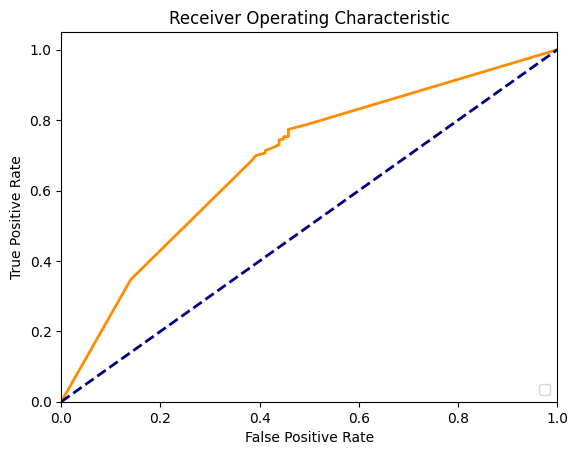

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(Y_test, pos_prob))

0.6857375752586637


### Tuning models with cross-validation


In [105]:
# 带超参数调优的分层K折交叉验证，用于评估多项式朴素贝叶斯(MultinomialNB)在不同平滑参数(alpha)和先验概率设置(fit_prior)下的性能。
from sklearn.model_selection import StratifiedKFold

k = 5
k_fold = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

smoothing_factor_option = [1,2,3,4,5,6]
fit_prior_option = [True, False]

auc_record = {}

for train_indices, test_indices in k_fold.split(X, Y):
    X_train_k, X_test_k = X[train_indices], X[test_indices]
    Y_train_k, Y_test_k = Y[train_indices], Y[test_indices]
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in fit_prior_option:
            clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
            clf.fit(X_train_k, Y_train_k)
            prediction_prob = clf.predict_proba(X_test_k)
            pos_prob = prediction_prob[:, 1]
            auc = roc_auc_score(Y_test_k, pos_prob)
            auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)


print('smoothing  fit prior  auc')
for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f'    {smoothing}        {fit_prior}    {auc/k:.5f}')


smoothing  fit prior  auc
    1        True    0.65280
    1        False    0.65274
    2        True    0.65108
    2        False    0.65274
    3        True    0.65313
    3        False    0.65322
    4        True    0.65397
    4        False    0.65430
    5        True    0.65455
    5        False    0.65448
    6        True    0.65478
    6        False    0.65404


In [106]:
clf = MultinomialNB(alpha=2.0, fit_prior=False)
clf.fit(X_train, Y_train)

pos_prob = clf.predict_proba(X_test)[:, 1]

print('AUC with the best model:', roc_auc_score(Y_test, pos_prob))

AUC with the best model: 0.6862056720417091
